In [1]:
import warnings ; warnings.filterwarnings('ignore')

import gym
import gym_bandits
import numpy as np
from tqdm import tqdm_notebook as tqdm

from itertools import cycle

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('fivethirtyeight')
matplotlib.rc('font', size=24)
matplotlib.rc('legend', fontsize=20)
matplotlib.rc('axes', titlesize=24)
matplotlib.rc('xtick', labelsize=20)
matplotlib.rc('ytick', labelsize=20)
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

np.set_printoptions(suppress=True)

I'm first going to add all the methods for the different exploration strategies

In [2]:
def random_strategy(env, n_trials=100000):
    Q = np.zeros((env.action_space.n))
    N = np.zeros((env.action_space.n))
    env.reset()

    returns = np.empty(n_trials)
    for t in tqdm(range(n_trials), desc='Random trials', leave=False):
        action = np.random.randint(env.action_space.n)
        _, reward, _, _ = env.step(action)
        N[action] += 1
        Q[action] = Q[action] + (reward - Q[action])/N[action]
        
        returns[t] = reward
    return np.cumsum(returns)/(np.arange(n_trials)+1)

In [3]:
def greedy_strategy(env, n_trials=100000):
    Q = np.zeros((env.action_space.n))
    N = np.zeros((env.action_space.n))
    env.reset()

    returns = np.empty(n_trials)
    for t in tqdm(range(n_trials), desc='Greedy trials', leave=False):
        action = np.argmax(Q)
        _, reward, _, _ = env.step(action)
        N[action] += 1
        Q[action] = Q[action] + (reward - Q[action])/N[action]
        
        returns[t] = reward
    return np.cumsum(returns)/(np.arange(n_trials)+1)

In [4]:
def e_greedy_strategy(env, epsilon=0.1, n_trials=100000):
    Q = np.zeros((env.action_space.n))
    N = np.zeros((env.action_space.n))
    env.reset()

    returns = np.empty(n_trials)
    for t in tqdm(range(n_trials), desc='E-greedy {} trials'.format(epsilon), leave=False):
        action = np.argmax(Q) if np.random.random() > epsilon else env.action_space.sample()
        _, reward, _, _ = env.step(action)
        N[action] += 1
        Q[action] = Q[action] + (reward - Q[action])/N[action]
        
        returns[t] = reward
    return np.cumsum(returns)/(np.arange(n_trials)+1)

In [5]:
def e_greedy_decay_strategy(env, initial_epsilon=1.0, decay_rate=1e-4, min_epsilon=0.0, n_trials=100000):
    Q = np.zeros((env.action_space.n))
    N = np.zeros((env.action_space.n))
    env.reset()

    returns = np.empty(n_trials)
    for t in tqdm(range(n_trials), desc='E-greedy decaying {} trials'.format(decay_rate), leave=False):
        epsilon = max(initial_epsilon * np.exp(-decay_rate * t), min_epsilon)
        action = np.argmax(Q) if np.random.random() > epsilon else env.action_space.sample()
        _, reward, _, _ = env.step(action)
        N[action] += 1
        Q[action] = Q[action] + (reward - Q[action])/N[action]
        
        returns[t] = reward
    return np.cumsum(returns)/(np.arange(n_trials)+1)

In [6]:
def optimistic_strategy(env, optimistic_estimate=1.0, n_trials=100000):
    Q = np.full((env.action_space.n), optimistic_estimate, dtype=np.float64)
    N = np.full((env.action_space.n), 100, dtype=np.float64)
    env.reset()
    
    returns = np.empty(n_trials)
    for t in tqdm(range(n_trials), desc='Optimistic {} trials'.format(optimistic_estimate), leave=False):
        action = np.argmax(Q)
        _, reward, _, _ = env.step(action)
        N[action] += 1
        Q[action] = Q[action] + (reward - Q[action])/N[action]
        
        returns[t] = reward
    return np.cumsum(returns)/(np.arange(n_trials)+1)

The function below will run the different experiments

In [7]:
def run_exploration_strategies_experiment(env):
    ret_r, ret_g = [], []
    ret_eg1, ret_eg2 = [], []
    ret_egd1, ret_egd2 = [], []
    ret_os1, ret_os2 = [], []
    
    for seed in tqdm([12, 34, 56, 78, 90], desc='Random seeds'):
        np.random.seed(seed)
        ret_r.append(random_strategy(env))
        ret_g.append(greedy_strategy(env))
        ret_eg1.append(e_greedy_strategy(env, epsilon=0.01))
        ret_eg2.append(e_greedy_strategy(env, epsilon=0.1))
        ret_egd1.append(e_greedy_decay_strategy(env, decay_rate=0.01))
        ret_egd2.append(e_greedy_decay_strategy(env, decay_rate=0.001))
        ret_os1.append(optimistic_strategy(env, optimistic_estimate=1))
        ret_os2.append(optimistic_strategy(env, optimistic_estimate=2))
    return (np.array(ret_r), 'random'), (np.array(ret_g), 'greedy'), \
        (np.array(ret_eg1), 'epsilon 0.01'), (np.array(ret_eg2), 'epsilon 0.1'), \
        (np.array(ret_egd1), 'decay 0.01 -> 0'), (np.array(ret_egd2), 'decay 0.001 -> 0'), \
        (np.array(ret_os1), 'optimistic 1'), (np.array(ret_os2), 'optimistic 2')

Now we can run the different algorithms and see how they perform on the bandit environment.

In [8]:
env = gym.make("BanditTwoArmedHighHighFixed-v0")
results = run_exploration_strategies_experiment(env)

WARN: Environment '<class 'gym_bandits.bandit.BanditTwoArmedHighHighFixed'>' has deprecated methods '_step' and '_reset' rather than 'step' and 'reset'. Compatibility code invoked. Set _gym_disable_underscore_compat = True to disable this behavior.


Let's now plot the cummulative reward obtained by these strategies. The first one is a log scale plot, the second one is a normal scale.

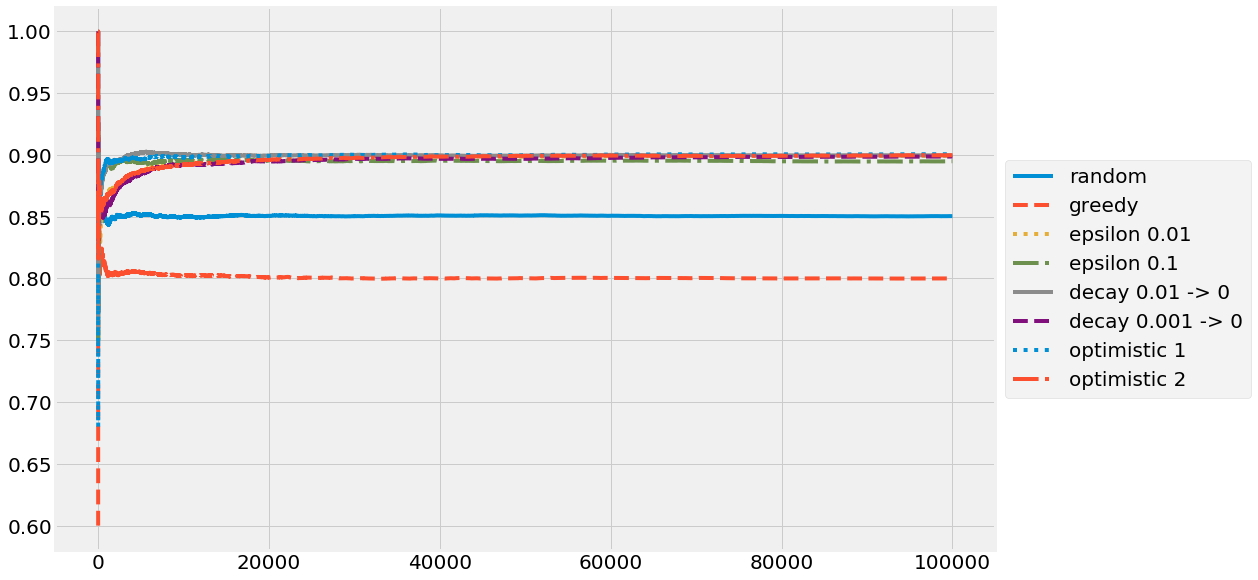

In [9]:
plt.figure(figsize=(15, 10))
lines = ["-","--",":","-."]
linecycler = cycle(lines)
for experiment, label in results:
    plt.plot(np.mean(experiment, axis=0), next(linecycler), label=label)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

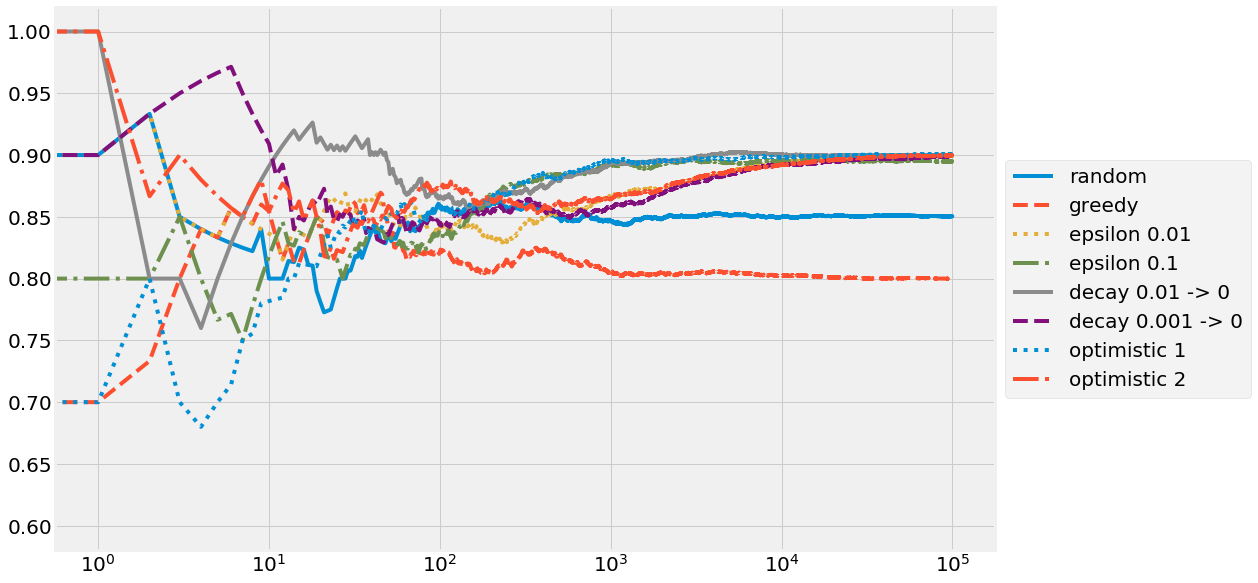

In [10]:
plt.figure(figsize=(15, 10))
lines = ["-","--",":","-."]
linecycler = cycle(lines)
for experiment, label in results:
    plt.plot(np.mean(experiment, axis=0), next(linecycler), label=label)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xscale('log')
plt.show()

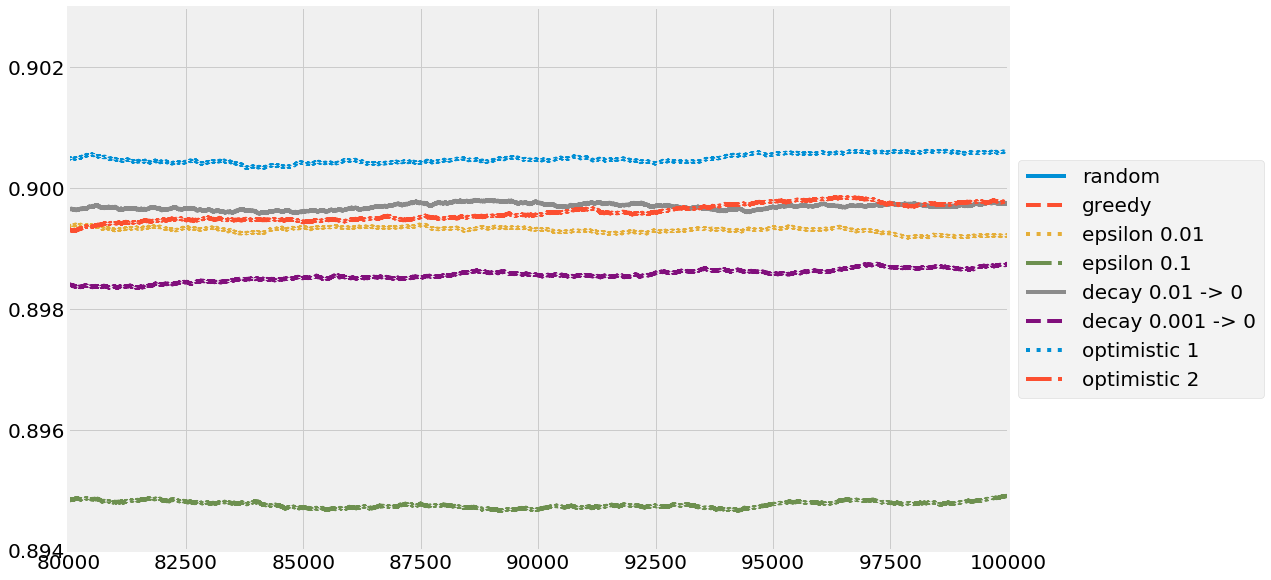

In [11]:
plt.figure(figsize=(15, 10))
lines = ["-","--",":","-."]
linecycler = cycle(lines)
for experiment, label in results:
    plt.plot(np.mean(experiment, axis=0), next(linecycler), label=label)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# x1,x2,y1,y2 = plt.axis()
# plt.axis((x1,x2,y1,y2))
plt.axis((80000,100000,0.894,0.903))
plt.show()

I now run the same strategies on a different environment, also a bandit but with 10 arms and a different reward payoff style.

In [12]:
env = gym.make("BanditTenArmedGaussian-v0")
results = run_exploration_strategies_experiment(env)

We plot the same two plots for this experiment as we did before.

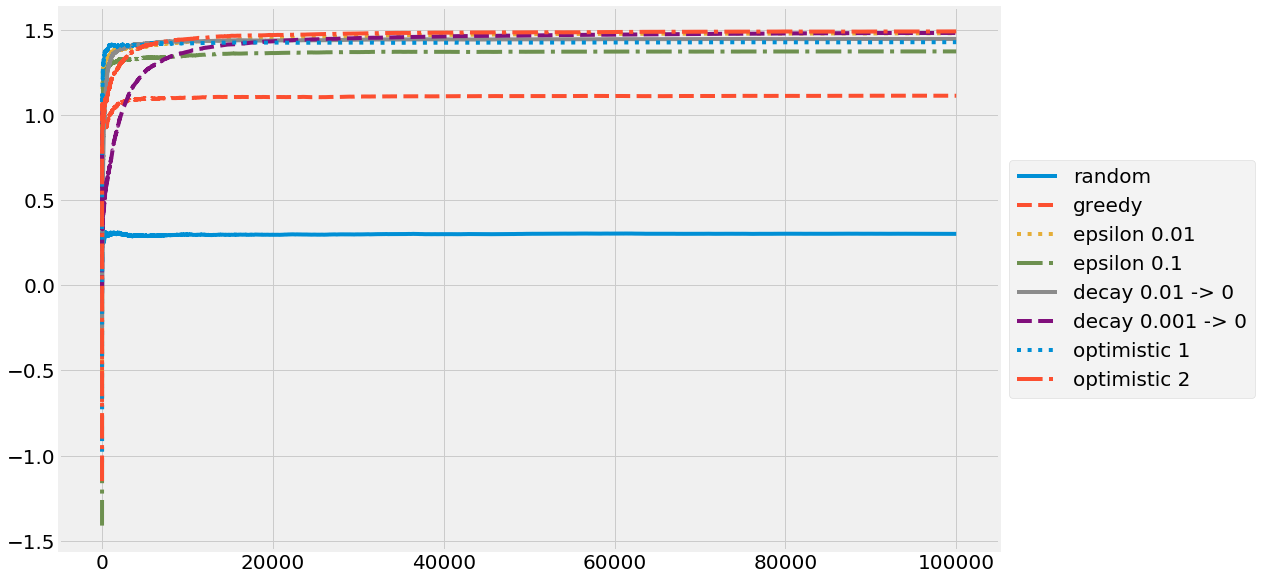

In [14]:
plt.figure(figsize=(15, 10))
lines = ["-","--",":","-."]
linecycler = cycle(lines)
for experiment, label in results:
    plt.plot(np.mean(experiment, axis=0), next(linecycler), label=label)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

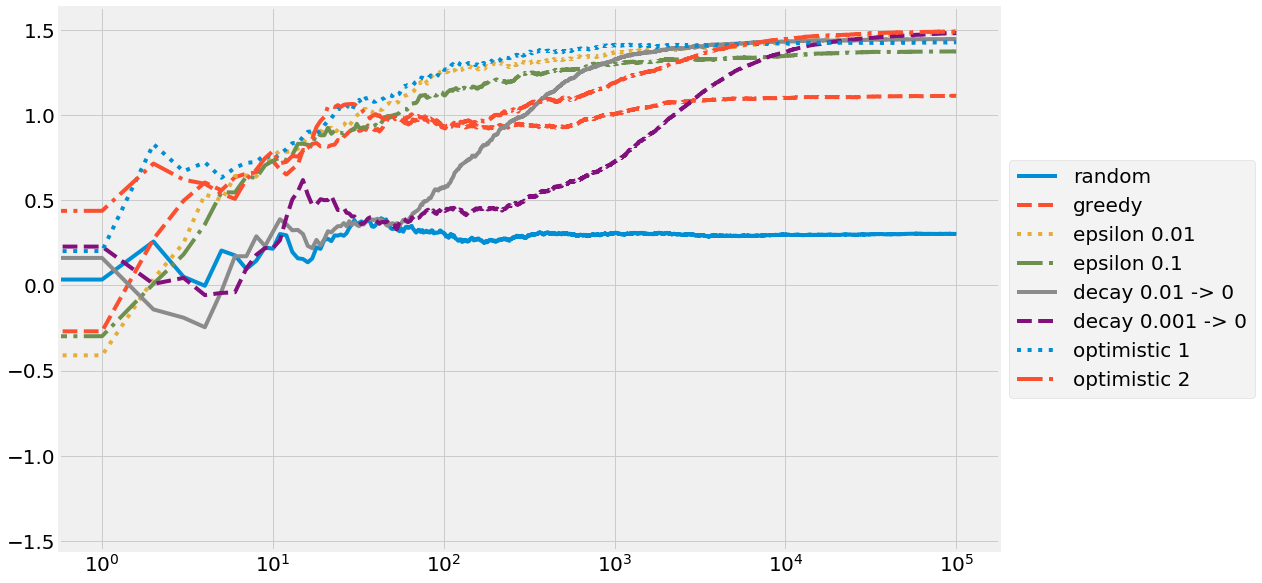

In [13]:
plt.figure(figsize=(15, 10))
lines = ["-","--",":","-."]
linecycler = cycle(lines)
for experiment, label in results:
    plt.plot(np.mean(experiment, axis=0), next(linecycler), label=label)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xscale('log')
plt.show()

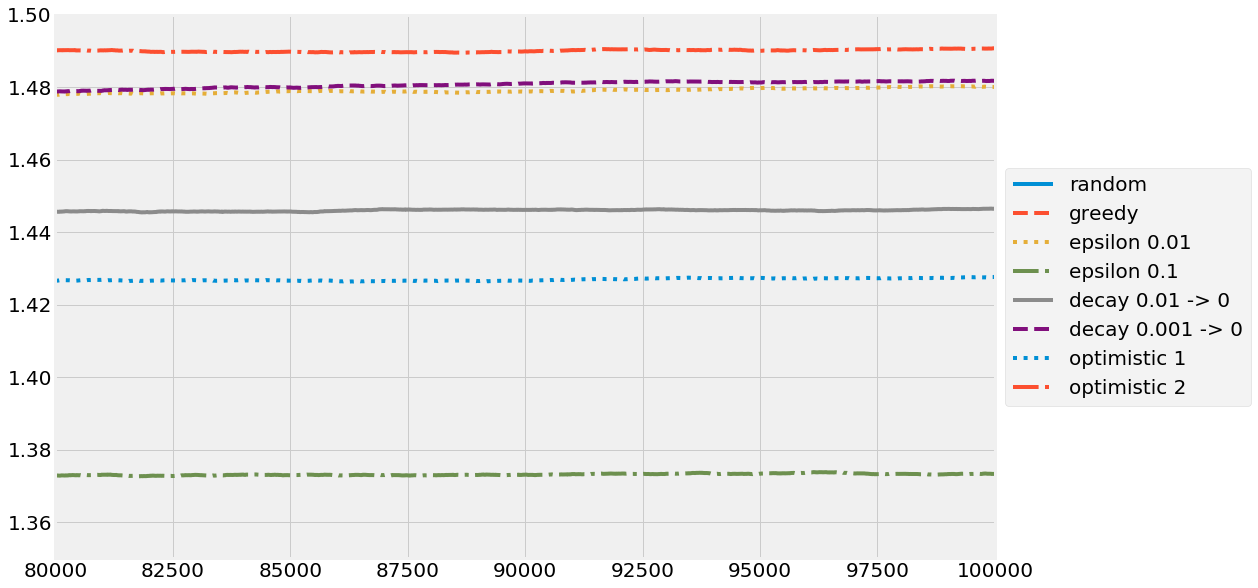

In [19]:
plt.figure(figsize=(15, 10))
lines = ["-","--",":","-."]
linecycler = cycle(lines)
for experiment, label in results:
    plt.plot(np.mean(experiment, axis=0), next(linecycler), label=label)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# x1,x2,y1,y2 = plt.axis()
# plt.axis((x1,x2,y1,y2))
plt.axis((80000,100000,1.35,1.5))
plt.show()

Explore a little bit the environment and try to understand more clearly how it is inside.

In [20]:
env.env.p_dist

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [21]:
env.env.r_dist

[[-1.461883296837311, 1],
 [1.3777733516663109, 1],
 [0.0390714597231955, 1],
 [-0.008383544810604857, 1],
 [0.3829472755157551, 1],
 [0.2009998576135767, 1],
 [1.0583504281353682, 1],
 [1.4955451703601752, 1],
 [-0.47428153671299106, 1],
 [0.4365551566931586, 1]]

We bring the same print policy function as before.

In [ ]:
def print_policy(pi, P):
    arrs = {k:v for k,v in enumerate(('<', 'v', '>', '^'))}
    for key, value in pi.items():
        print("| ", end="")
        if P[key][0][0][0] == 1.0:
            print("    ", end=" ")
        else:
            print(str(key).zfill(2), arrs[value], end=" ")
        if (key + 1) % np.sqrt(len(pi)) == 0: print("|")

Add a method to print value functions to better illustrate the update style of the different model-free reinforcement learning methods

In [ ]:
def plot_value_function(V_track, log=False):
    per_col = 25
    plt.figure(figsize=(15, 10))
    linecycler = cycle(["-","--",":","-."])
    legends = []
    for i, state in enumerate(V_track.T):
        p, = plt.plot(state, next(linecycler), label=str('State {}'.format(i)))
        legends.append(p)
    ls = []
    for loc, idx in enumerate(range(0, len(legends), per_col)):
        subset = legends[idx:idx+per_col]
        l = plt.legend(subset, [p.get_label() for p in subset], 
                       loc='center left', bbox_to_anchor=(1+loc*0.15, 0.5))
        ls.append(l)
    [plt.gca().add_artist(l) for l in ls[:-1]]
    if log: plt.xscale('log')
    plt.show()

I create a function to check for the probability of success of a policy. This will allow us to test policies empirically.

In [ ]:
def probability_success(env, pi, iterations=10000):
    rewards = []
    for i in range(iterations):
        state, done = env.reset(), False
        while not done:
            state, reward, done, _ = env.step(pi[state])
            rewards.append(reward)
    return np.sum(rewards)/iterations*iterations/100

We bring the same policy and environment as we had in the previous chapter.

In [ ]:
env = gym.make('FrozenLake-v0')
LEFT, DOWN, RIGHT, UP = range(4)
pi = {
    0:RIGHT,  1:LEFT,   2:DOWN,  3:UP,
    4:LEFT,   5:LEFT,   6:RIGHT, 7:LEFT,
    8:UP,     9:DOWN,  10:UP,   11:LEFT,
    12:LEFT, 13:RIGHT, 14:DOWN, 15:LEFT
}

I bring the policy evaluation algorithm to use it as a reference. This algorithm can find a true state-value function, while the new methods you're learning about find only approximate state-value functions.

In [ ]:
def policy_evaluation(pi, P, gamma=0.9, theta=1e-10):
    V = np.zeros(len(pi))
    V_track = []
    while True:
        max_delta = 0
        old_V = V.copy()

        for s in range(len(P)):
            V[s] = 0
            for prob, new_state, reward, done in P[s][pi[s]]:
                if done:
                    value = reward
                else:
                    value = reward + gamma * old_V[new_state]
                V[s] += prob * value
            max_delta = max(max_delta, abs(old_V[s] - V[s]))
        V_track.append(V.copy())
        if max_delta < theta:
            break
    return V.copy(), np.array(V_track)

V, V_track = policy_evaluation(pi, env.env.P)
V, V_track

I'm plotting the state-value function that came out of policy evaluation. Check out the smoothness of the values. As the number of iterations increase, we converge to the true values.

In [ ]:
plot_value_function(V_track, True)

In [ ]:
plot_value_function(V_track)

We now add a couple of methods to run Monte-Carlo prediction. The first method just generates an episode by running a policy in an environment.

In [ ]:
def generate_episode(pi, env, max_steps):
    episode = []
    state = env.reset()
    for t in range(max_steps):
        action = pi[state] 
        new_state, reward, done, _ = env.step(action)
        episode.append((state, action, reward, new_state, done))
        if done:
            break
        state = new_state
    return np.array(episode, np.object)

The second method is the algorithm itself.

In [ ]:
def mc_prediction(pi, 
                  env, 
                  gamma=0.9, 
                  initial_alpha=0.2, 
                  alpha_decay_rate=1e-3, 
                  min_alpha=0.0, 
                  n_episodes=10000, 
                  max_steps=500):
    nS = env.observation_space.n
    discounts = np.logspace(0, max_steps, num=max_steps, base=gamma, endpoint=False)
    V = np.zeros(nS)
    V_track = np.zeros((n_episodes, nS))
    
    for t in tqdm(range(n_episodes)):
        alpha = max(initial_alpha * np.exp(-alpha_decay_rate * t), min_alpha)
        episode = generate_episode(pi, env, max_steps)
        return_visited = np.zeros(nS, dtype=np.bool)
        for step_idx, (state, _, reward, _, _) in enumerate(episode):
            if return_visited[state]:
                continue
            return_visited[state] = True

            seq_len = len(episode[step_idx:])
            G = np.sum(discounts[:seq_len] * episode[step_idx:, 2])

            V[state] = V[state] + alpha * (G - V[state])
        V_track[t] = V
    return V.copy(), V_track

V, V_track = mc_prediction(pi, env)
V

Next is the true state-value function we found with policy evaluation. Just for reference and comparison.

In [ ]:
np.array([ 0.02134932,  0.00914971,  0.00980529,  0.00735397,  0.04066537,
           0.        ,  0.01618064,  0.        ,  0.07353654,  0.13091989,
           0.04413016,  0.        ,  0.        ,  0.31873294,  0.61279031,  0.        ])

Now we print the value function as found by Monte-Carlo prediction. See how the smoothness is gone? Lots of variance here.

In [ ]:
plot_value_function(V_track, True)

In [ ]:
plot_value_function(V_track)

Now we introduce temporal-difference learning.

In [ ]:
def td(pi, 
       env, 
       gamma=0.9, 
       initial_alpha=0.2, 
       alpha_decay_rate=1e-3, 
       min_alpha=0.0, 
       n_episodes=10000):
    nS = env.observation_space.n
    V = np.zeros(nS)
    V_track = np.zeros((n_episodes, nS))
    
    for t in tqdm(range(n_episodes)):
        alpha = max(initial_alpha * np.exp(-alpha_decay_rate * t), min_alpha)

        state, done = env.reset(), False
        while not done:
            action = pi[state]
            new_state, reward, done, _ = env.step(action)
            td_error = reward + gamma * V[new_state] - V[state]
            V[state] = V[state] + alpha * td_error
            state = new_state
        V_track[t] = V
    return V.copy(), V_track

V, V_track = td(pi, env)
V

See the estimated values and compare them with the true values below.

In [ ]:
np.array([ 0.02134932,  0.00914971,  0.00980529,  0.00735397,  0.04066537,
           0.        ,  0.01618064,  0.        ,  0.07353654,  0.13091989,
           0.04413016,  0.        ,  0.        ,  0.31873294,  0.61279031,  0.        ])

Now we plot the TD state-value function. Observe how the variance is not as large, the values more a bit more continuously than MC, however, you can see how TD is biased. Look at the final values of each states and trace them back. Notice how the variance occurs either above or below the final value, but not in between like for MC. TD has low variance and it is biased, MC has high variance and no bias.

In [ ]:
plot_value_function(V_track, True)

In [ ]:
plot_value_function(V_track)

We now bring the full 8x8 Frozen Lake environment and we will modify it to be an 80%, 10%, and 10%. 

In [ ]:
env = gym.make('FrozenLake8x8-v0')

# change transition function
prob_action, drift_right, drift_left = 0.8, 0.1, 0.1
for s in range(len(env.env.P)):
    for a in range(len(env.env.P[s])):
        for t in range(len(env.env.P[s][a])):
            if env.env.P[s][a][t][0] == 1.0:
                continue
            values = list(env.env.P[s][a][t])
            if t == 0:
                values[0] = drift_left
            elif t == 1:
                values[0] = prob_action
            elif t == 2:
                values[0] = drift_right
            env.env.P[s][a][t] = tuple(values)

I'm now bring back value iteration to calculate the optimal state-value function and optimal policy. We need them for comparisons will later algorithms.

In [ ]:
def value_iteration(P, gamma=0.9, theta=1e-10):

    V = np.random.random(len(P))
    V_track = []
    while True:
        max_delta = 0
        Q = np.zeros((len(P), len(P[0])), dtype=np.float64)

        for s in range(len(P)):
            v = V[s]
            for a in range(len(P[s])):
                for prob, new_state, reward, done in P[s][a]:
                    if done:
                        value = reward
                    else:
                        value = reward + gamma * V[new_state]
                    Q[s][a] += prob * value
            V[s] = np.max(Q[s])
            max_delta = max(max_delta, abs(v - V[s]))
        V_track.append(V.copy())
        if max_delta < theta:
            break
    pi = {s:a for s, a in enumerate(np.argmax(Q, axis=1))}
    return V, pi, np.array(V_track)
env = gym.make('Taxi-v2')
V_best, pi_best, V_track = value_iteration(env.env.P, gamma=0.9)
V_best, pi_best

Calculate the probability of success of an optimal policy

In [ ]:
probability_success(env, pi_best)

Print the optimal policy

In [ ]:
print_policy(pi_best, env.env.P)

Plot state-value function

In [ ]:
plot_value_function(V_track, True)

In [ ]:
plot_value_function(V_track)

I'm now adding an e-soft policy class that will help us with the Monte-Carlo control.

In [ ]:
class ESoftPolicy:
    def __init__(self, nS, nA, epsilon=0.2):
        self.nA = nA
        self.nS = nS
        self.epsilon = epsilon
        self.probs = np.random.dirichlet(np.ones(self.nA), size=self.nS)
        for state in range(self.nS):
            action = np.random.randint(self.nA)
            self.readjust_probs(state, action, epsilon)

    def __getitem__(self, state):
        return np.random.choice(self.nA, p=self.probs[state])

    def readjust_probs(self, state, best_action, epsilon):
        self.epsilon = epsilon
        prob_best = 1 - self.epsilon + self.epsilon/self.nA
        prob_other = self.epsilon/self.nA
        new_probs = [prob_other,] * (self.nA - 1)
        new_probs.insert(best_action, prob_best)
        self.probs[state] = new_probs

Now add the Monte-Carlo approach to finding optimal policies.

In [ ]:
def on_policy_mc_control(env,
                         gamma = 0.9,
                         initial_epsilon = 1.0,
                         epsilon_decay_rate = 1e-5,
                         min_epsilon = 0.01,
                         initial_alpha=0.5, 
                         alpha_decay_rate=1e-3, 
                         min_alpha=0.001, 
                         max_steps=500,
                         n_episodes=100000):
    nS, nA = env.observation_space.n, env.action_space.n
    discounts = np.logspace(0, max_steps, num=max_steps, base=gamma, endpoint=False)
    
    Q = np.zeros((nS, nA))
    Q_track = np.zeros((n_episodes, nS, nA))
    pi = ESoftPolicy(nS, nA, initial_epsilon)

    for t in tqdm(range(n_episodes)):
        epsilon = max(initial_epsilon * np.exp(-epsilon_decay_rate * t), min_epsilon)
        alpha = max(initial_alpha * np.exp(-alpha_decay_rate * t), min_alpha)
        
        episode = generate_episode(pi, env, max_steps)
        return_visited = np.zeros((nS, nA), dtype=bool)
        for step_idx, (state, action, reward, _, _) in enumerate(episode):
            if return_visited[state][action]:
                continue
            return_visited[state][action] = True
            
            seq_len = len(episode[step_idx:])
            G = np.sum(discounts[:seq_len] * episode[step_idx:, 2])
            Q[state][action] = Q[state][action] + alpha * (G - Q[state][action])
            
        Q_track[t] = Q
        _, uidxs = np.unique(episode[:,0], return_index=True)
        for idx in uidxs:
            state, action, reward, _, _ = episode[idx]
            best_action = np.argmax(Q[state])
            pi.readjust_probs(state, best_action, epsilon)

    pi = {s:a for s, a in enumerate(np.argmax(Q, axis=1))}
    V = np.max(Q, axis=1)
    return Q, V, pi, Q_track

Q_best, V_best, pi_best, Q_track = on_policy_mc_control(env)
Q_best, V_best, pi_best

Now check the probability of success of the policy found by on-policy Monte-Carlo. 

In [ ]:
probability_success(env, pi_best)

Print the policy found by the algorithm

In [ ]:
print_policy(pi_best, env.env.P)

We now plot the Q function, that is the action-value function.

In [ ]:
plot_value_function(np.max(Q_track, axis=2), True)

In [ ]:
plot_value_function(np.max(Q_track, axis=2))

We now introduce the off-policy TD control. The popular Q-Learning.

In [ ]:
def q_learning(env, 
               gamma = 0.9,
               initial_alpha = 0.5,
               alpha_decay_rate = 1e-3,
               min_alpha = 0.001,
               initial_epsilon = 1.,
               epsilon_decay_rate = 1e-5,
               min_epsilon = 0.0,
               n_episodes=100000):

    nS, nA = env.observation_space.n, env.action_space.n
    Q = np.zeros((nS, nA))
    Q_track = np.zeros((n_episodes, nS, nA))
    select_action = lambda state, Q, epsilon: np.argmax(Q[state]) \
        if np.random.random() > epsilon \
        else np.random.randint(nA)
    
    for t in tqdm(range(n_episodes)):
        alpha = max(initial_alpha * np.exp(-alpha_decay_rate * t), min_alpha)
        epsilon = max(initial_epsilon * np.exp(-epsilon_decay_rate * t), min_epsilon)
        state, done = env.reset(), False
        while not done:
            action = select_action(state, Q, epsilon)
            new_state, reward, done, _ = env.step(action)
            if done:
                Q[new_state] = 0.
                Q_est = reward
            else: 
                Q_est = reward + gamma * Q[new_state].max()
            Q[state][action] = Q[state][action] + alpha * (Q_est - Q[state][action])
            state = new_state
        Q_track[t] = Q

    pi = {s:a for s, a in enumerate(np.argmax(Q, axis=1))}
    V = np.max(Q, axis=1)
    return Q, V, pi, Q_track

Q_best, V_best, pi_best, Q_track = q_learning(env)
Q_best, V_best, pi_best

Check the probability of success and the Q values just as before.

In [ ]:
probability_success(env, pi_best)

In [ ]:
print_policy(pi_best, env.env.P)

In [ ]:
plot_value_function(np.max(Q_track, axis=2), True)

In [ ]:
plot_value_function(np.max(Q_track, axis=2))

We now introduce the on-policy TD method, SARSA.

In [ ]:
def sarsa(env,
          gamma = 0.9,
          initial_alpha = 1.0,
          alpha_decay_rate = 5e-4,
          min_alpha = 1e-4,
          initial_epsilon = 1.,
          epsilon_decay_rate = 1e-5,
          min_epsilon = 0.0,
          n_episodes=100000):

    nS, nA = env.observation_space.n, env.action_space.n
    Q = np.zeros((nS, nA))
    Q_track = np.zeros((n_episodes, nS, nA))
    select_action = lambda state, Q, epsilon: np.argmax(Q[state]) \
        if np.random.random() > epsilon \
        else np.random.randint(nA)
    
    for t in tqdm(range(n_episodes)):
        alpha = max(initial_alpha * np.exp(-alpha_decay_rate * t), min_alpha)
        epsilon = max(initial_epsilon * np.exp(-epsilon_decay_rate * t), min_epsilon)
        state, done = env.reset(), False
        action = select_action(state, Q, epsilon)
        while not done:
            new_state, reward, done, _ = env.step(action)
            new_action = select_action(new_state, Q, epsilon)
            
            if done:
                Q[new_state] = 0.
                Q_est = reward
            else: 
                Q_est = reward + gamma * Q[new_state][new_action]
            Q[state][action] += alpha * (Q_est - Q[state][action])
            state, action = new_state, new_action
        Q_track[t] = Q

    pi = {s:a for s, a in enumerate(np.argmax(Q, axis=1))}
    V = np.max(Q, axis=1)
    return Q, V, pi, Q_track

Q_best, V_best, pi_best, Q_track = sarsa(env)
Q_best, V_best, pi_best

Print the probabilities of success, policy and Q values

In [ ]:
probability_success(env, pi_best)

In [ ]:
print_policy(pi_best, env.env.P)

In [ ]:
plot_value_function(np.max(Q_track, axis=2), True)

In [ ]:
plot_value_function(np.max(Q_track, axis=2))

Now, we run double_q_learning, a more stable version of Q-Learning.

In [ ]:
def double_q_learning(env,
                      gamma = 0.9,
                      initial_alpha = 0.5,
                      alpha_decay_rate = 1e-3,
                      min_alpha = 0.001,
                      initial_epsilon = 1.,
                      epsilon_decay_rate = 1e-5,
                      min_epsilon = 0.01,
                      n_episodes=300000):

    nS, nA = env.observation_space.n, env.action_space.n
    Q1 = np.zeros((nS, nA))
    Q2 = np.zeros((nS, nA))
    Q_track1 = np.zeros((n_episodes, nS, nA))
    Q_track2 = np.zeros((n_episodes, nS, nA))
    select_action = lambda state, Q, epsilon: np.argmax(Q[state]) \
        if np.random.random() > epsilon \
        else np.random.randint(nA)
    
    for t in tqdm(range(n_episodes)):
        alpha = max(initial_alpha * np.exp(-alpha_decay_rate * t), min_alpha)
        epsilon = max(initial_epsilon * np.exp(-epsilon_decay_rate * t), min_epsilon)
        state, done = env.reset(), False
        while not done:
            action = select_action(state, Q1+Q2, epsilon)
            new_state, reward, done, _ = env.step(action)
            
            if done: 
                Q1[new_state] = 0.
                Q2[new_state] = 0.

            if np.random.randint(2):
                argmax_Q1 = np.argmax(Q1[new_state])
                Q2_est = reward if done else reward + gamma * Q2[new_state][argmax_Q1]
                Q1[state][action] += alpha * (Q2_est - Q1[state][action])
            else:
                argmax_Q2 = np.argmax(Q2[new_state])
                Q1_est = reward if done else reward + gamma * Q1[new_state][argmax_Q2]
                Q2[state][action] += alpha * (Q1_est - Q2[state][action])

            state = new_state
        Q_track1[t] = Q1
        Q_track2[t] = Q2

    Q = (Q1 + Q2)/2.
    pi = {s:a for s, a in enumerate(np.argmax(Q, axis=1))}
    V = np.max(Q, axis=1)
    return Q, V, pi, Q_track1, Q_track2

Q_best, V_best, pi_best, Q_track1, Q_track2 = double_q_learning(env)
Q_best, V_best, pi_best

And the same values as before for comparison

In [ ]:
probability_success(env, pi_best)

In [ ]:
print_policy(pi_best, env.env.P)

In [ ]:
plot_value_function(np.max(Q_track1, axis=2), True)

In [ ]:
plot_value_function(np.max(Q_track1, axis=2))

In [ ]:
plot_value_function(np.max(Q_track2, axis=2), True)

In [ ]:
plot_value_function(np.max(Q_track2, axis=2))